In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        (os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2

In [20]:
input_dir = "/kaggle/input/brain-tumor-segmentation/images"
target_dir = "/kaggle/input/brain-tumor-segmentation/masks"
img_size = (128, 128)
num_classes = 3
batch_size = 16

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 3064
/kaggle/input/brain-tumor-segmentation/images/1.png | /kaggle/input/brain-tumor-segmentation/masks/1.png
/kaggle/input/brain-tumor-segmentation/images/10.png | /kaggle/input/brain-tumor-segmentation/masks/10.png
/kaggle/input/brain-tumor-segmentation/images/100.png | /kaggle/input/brain-tumor-segmentation/masks/100.png
/kaggle/input/brain-tumor-segmentation/images/1000.png | /kaggle/input/brain-tumor-segmentation/masks/1000.png
/kaggle/input/brain-tumor-segmentation/images/1001.png | /kaggle/input/brain-tumor-segmentation/masks/1001.png
/kaggle/input/brain-tumor-segmentation/images/1002.png | /kaggle/input/brain-tumor-segmentation/masks/1002.png
/kaggle/input/brain-tumor-segmentation/images/1003.png | /kaggle/input/brain-tumor-segmentation/masks/1003.png
/kaggle/input/brain-tumor-segmentation/images/1004.png | /kaggle/input/brain-tumor-segmentation/masks/1004.png
/kaggle/input/brain-tumor-segmentation/images/1005.png | /kaggle/input/brain-tumor-segmentation/mask

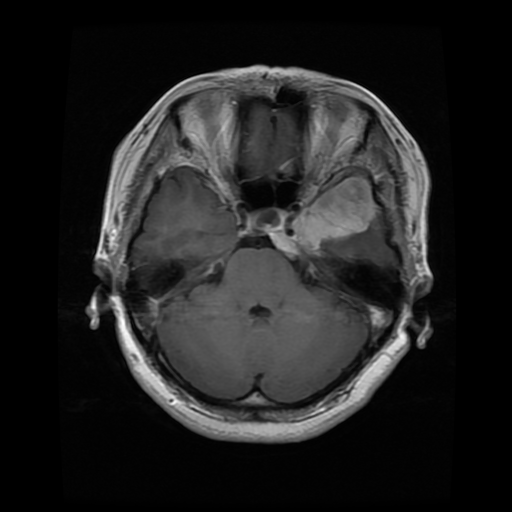

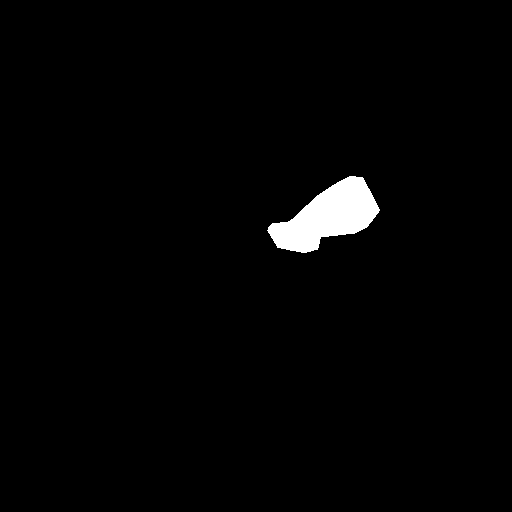

In [21]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[0]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(target_img_paths[0]))
display(img)

In [25]:
image_with = 128

tar_images = []

data_path = "/kaggle/input/brain-tumor-segmentation/images"

for directory_path in glob.glob(data_path):
    for img_path in glob.glob(os.path.join(directory_path, "*.png"))[0:1000]:
        img = cv2.imread(img_path, 1) #cv2.IMREAD_GRAYSCALE       
        img = cv2.resize(img, img_size)
        tar_images.append(img)
       
#Convert list to array for machine learning processing        
tar_images = np.array(tar_images)
tar_images = tar_images.reshape(len(tar_images), image_with, image_with, 3)
print(tar_images.shape)

masks = []

data_path = "/kaggle/input/brain-tumor-segmentation/masks"

for directory_path in glob.glob(data_path):
    for img_path in glob.glob(os.path.join(directory_path, "*.png"))[0:1000]:
        img = cv2.imread(img_path, 1) #cv2.IMREAD_GRAYSCALE       
        img = cv2.resize(img, img_size)
        masks.append(img)
       
#Convert list to array for machine learning processing        
masks = np.array(masks)
masks = masks.reshape(len(masks), image_with, image_with, 3)
print(masks.shape)

(1000, 128, 128, 3)
(1000, 128, 128, 3)


In [26]:
image_dataset = tar_images/255.
mask_dataset = masks/255.

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(900, 128, 128, 3)
(100, 128, 128, 3)
(900, 128, 128, 3)
(100, 128, 128, 3)


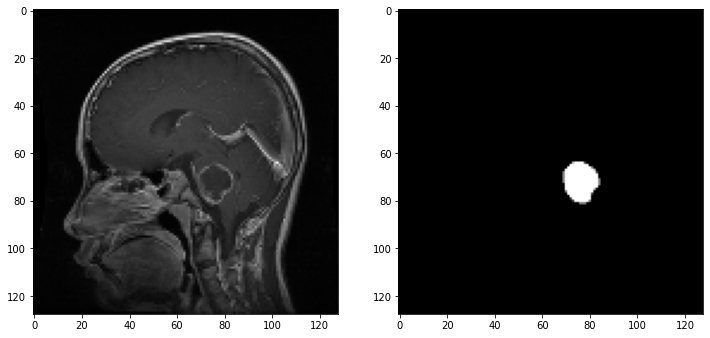

In [28]:
#Sanity check, view few mages
import matplotlib.pyplot as plt
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')
plt.show()

In [11]:
# Building Unet by dividing encoder and decoder into blocks

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
# from tf.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    b1 = conv_block(p4, 512) #Bridge

    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(3, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [12]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

2022-12-12 11:23:51.270890: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 11:23:51.272222: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 11:23:51.441943: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 11:23:51.442832: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 11:23:51.443641: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________

In [13]:
history = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=40, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)


2022-12-12 11:23:55.617072: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 566231040 exceeds 10% of free system memory.
2022-12-12 11:23:56.455067: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 566231040 exceeds 10% of free system memory.
2022-12-12 11:23:57.133265: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 566231040 exceeds 10% of free system memory.
2022-12-12 11:23:57.592961: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 566231040 exceeds 10% of free system memory.
2022-12-12 11:23:58.090088: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2022-12-12 11:24:01.785715: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-12-12 11:24:14.645724: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-12-12 11:24:14.645835: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-12-12 11:24:15.193902: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory

12/12 [==============================] - 44s 2s/step - loss: 0.5058 - accuracy: 0.0634 - val_loss: 1.2211 - val_accuracy: 0.0102
Epoch 2/40
12/12 [==============================] - 16s 1s/step - loss: 0.3268 - accuracy: 0.0056 - val_loss: 2.8209 - val_accuracy: 0.0022
Epoch 3/40
12/12 [==============================] - 16s 1s/step - loss: 0.2728 - accuracy: 8.6924e-04 - val_loss: 0.4489 - val_accuracy: 0.0080
Epoch 4/40
12/12 [==============================] - 16s 1s/step - loss: 0.2450 - accuracy: 0.0015 - val_loss: 0.6902 - val_accuracy: 0.0198
Epoch 5/40
12/12 [==============================] - 17s 1s/step - loss: 0.2185 - accuracy: 4.7972e-04 - val_loss: 0.5864 - val_accuracy: 0.2432
Epoch 6/40
12/12 [==============================] - 17s 1s/step - loss: 0.1994 - accuracy: 6.6728e-04 - val_loss: 0.3136 - val_accuracy: 0.0012
Epoch 7/40
12/12 [==============================] - 17s 1s/step - loss: 0.1799 - accuracy: 4.4946e-04 - val_loss: 0.2668 - val_accuracy: 0.0000e+00
Epoch 8/40


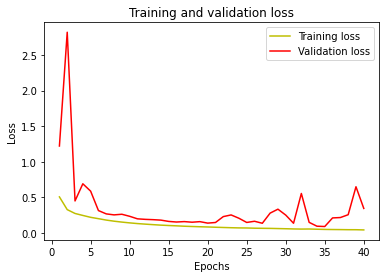

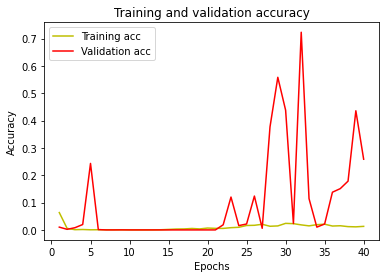

In [14]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

from tensorflow.keras.metrics import MeanIoU

n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())
# print('F1 Score: %.3f' % f1_score(y_test, y_pred_thresholded))

from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall

prec_score = Precision()
prec_score.update_state(y_pred_thresholded, y_test)
p = prec_score.result().numpy()
print('Precision Score: %.3f' % p)

recall_score = Recall()
recall_score.update_state(y_pred_thresholded, y_test)
r = recall_score.result().numpy()
print('Recall Score: %.3f' % r)

f1_score = 2*(p*r)/(p+r)
print('F1 Score: %.3f' % f1_score)

Mean IoU = 0.44283742
Precision Score: 0.761
Recall Score: 0.072
F1 Score: 0.132


(1, 512, 512, 3)
(512, 512)


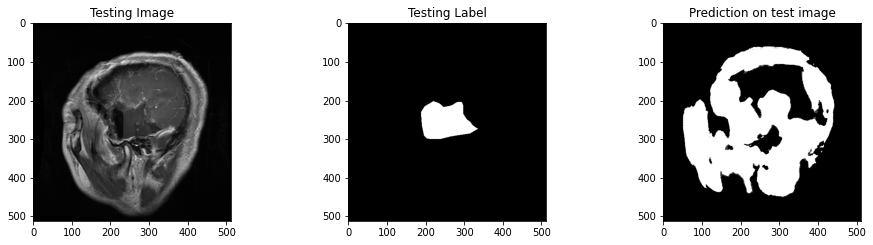

In [16]:
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

### **Res-UNet**

In [17]:
# Building Unet by dividing encoder and decoder into blocks

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
# from tf.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)
    
    x1 = Conv2D(num_filters, 3, padding="same")(x)
    x1 = BatchNormalization()(x1)  #Not in the original network
    x1 = Activation("relu")(x1)
    x2 =  x + x1
    
    x = Conv2D(num_filters, 3, padding="same")(x2)
    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    b1 = conv_block(p4, 512) #Bridge

    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(3, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="Res-UNet")
    return model

In [18]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model_resunet = build_unet(input_shape, n_classes=1)
model_resunet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model_resunet.summary()

sigmoid
Model: "Res-UNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 512, 512, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 512, 512, 32) 128         conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 512, 512, 32) 0           batch_normalization_18[0][0]     
___________________________________________________________________________________

In [19]:
history_resunet = model_resunet.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=40, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

2022-12-12 11:36:34.745382: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 566231040 exceeds 10% of free system memory.


Epoch 1/40


2022-12-12 11:36:50.198376: W tensorflow/core/common_runtime/bfc_allocator.cc:457] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.00GiB (rounded to 1073741824)requested by op Res-UNet/concatenate_7/concat
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-12-12 11:36:50.198458: I tensorflow/core/common_runtime/bfc_allocator.cc:1004] BFCAllocator dump for GPU_0_bfc
2022-12-12 11:36:50.198484: I tensorflow/core/common_runtime/bfc_allocator.cc:1011] Bin (256): 	Total Chunks: 301, Chunks in use: 301. 75.2KiB allocated for chunks. 75.2KiB in use in bin. 40.5KiB client-requested in use in bin.
2022-12-12 11:36:50.198499: I tensorflow/core/common_runtime/bfc_allocator.cc:1011] Bin (512): 	Total Chunks: 115, Chunks in use: 114. 58.0KiB allocated for chunks. 57.5KiB in use in bin. 56.2KiB client-requested in use in bin.
202

ResourceExhaustedError:  OOM when allocating tensor with shape[16,64,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node Res-UNet/concatenate_7/concat (defined at tmp/ipykernel_23/91488483.py:6) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_13376]

Function call stack:
train_function


In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history_resunet.history['loss']
val_loss = history_resunet.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history_resunet.history['accuracy']
val_acc = history_resunet.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#IOU
y_pred=model_resunet.predict(X_test)
y_pred_thresholded = y_pred > 0.5

from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall

prec_score = Precision()
prec_score.update_state(y_pred_thresholded, y_test)
p = prec_score.result().numpy()
print('Precision Score: %.3f' % p)

recall_score = Recall()
recall_score.update_state(y_pred_thresholded, y_test)
r = recall_score.result().numpy()
print('Recall Score: %.3f' % r)

f1_score = 2*(p*r)/(p+r)
print('F1 Score: %.3f' % f1_score)

In [ ]:
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model_resunet.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

### **Inception-based UNet****

In [ ]:
# Building Unet by dividing encoder and decoder into blocks

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
# from tf.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x1 = Conv2D(num_filters, 3, padding="same")(input)
    x1 = BatchNormalization()(x1)   #Not in the original network. 
    x1 = Activation("relu")(x1)
    
    x2 = Conv2D(num_filters, 5, padding="same")(input)
    x2 = BatchNormalization()(x2)  #Not in the original network
    x2 = Activation("relu")(x2)
    
    x3 = Conv2D(num_filters, 7, padding="same")(input)
    x3 = BatchNormalization()(x3)  #Not in the original network
    x3 = Activation("relu")(x3)
    
    x4 = Concatenate()([x1, x2, x3])
    
    x = Conv2D(num_filters, 3, padding="same")(x4)
    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    b1 = conv_block(p4, 512) #Bridge

    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(3, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="Inseption-UNet")
    return model

In [ ]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model_insunet = build_unet(input_shape, n_classes=1)
model_insunet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model_insunet.summary()

In [ ]:
history_insunet = model_insunet.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=40, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history_insunet.history['loss']
val_loss = history_insunet.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history_insunet.history['accuracy']
val_acc = history_insunet.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#IOU
y_pred=model_insunet.predict(X_test)
y_pred_thresholded = y_pred > 0.5

from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall

prec_score = Precision()
prec_score.update_state(y_pred_thresholded, y_test)
p = prec_score.result().numpy()
print('Precision Score: %.3f' % p)

recall_score = Recall()
recall_score.update_state(y_pred_thresholded, y_test)
r = recall_score.result().numpy()
print('Recall Score: %.3f' % r)

f1_score = 2*(p*r)/(p+r)
print('F1 Score: %.3f' % f1_score)

In [ ]:
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model_insunet.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

### **Proposed U-Net model**

In [31]:
# Building Unet by dividing encoder and decoder into blocks

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
# from tf.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("LeakyReLU")(x)
    x1 = Concatenate()([x, input])
    x = Conv2D(num_filters, 5, padding="same")(x1)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("LeakyReLU")(x)
    x = Concatenate()([input, x1, x])
    x = Conv2D(num_filters, 1, padding="same")(x)
    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    b1 = conv_block(p4, 512) #Bridge

    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(3, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [32]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model_prop = build_unet(input_shape, n_classes=1)
model_prop.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model_prop.summary()

sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 128, 128, 32) 896         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_37 (BatchNo (None, 128, 128, 32) 128         conv2d_48[0][0]                  
__________________________________________________________________________________________________
activation_37 (Activation)      (None, 128, 128, 32) 0           batch_normalization_37[0][0]     
______________________________________________________________________________________

In [33]:
history = model_prop.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=40, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/40
57/57 [==============================] - 28s 322ms/step - loss: 0.1111 - accuracy: 0.3321 - val_loss: 0.1376 - val_accuracy: 0.4289
Epoch 2/40
57/57 [==============================] - 14s 238ms/step - loss: 0.0492 - accuracy: 0.3942 - val_loss: 0.0921 - val_accuracy: 0.4497
Epoch 3/40
57/57 [==============================] - 13s 236ms/step - loss: 0.0421 - accuracy: 0.3499 - val_loss: 0.1063 - val_accuracy: 0.4110
Epoch 4/40
57/57 [==============================] - 13s 234ms/step - loss: 0.0363 - accuracy: 0.3567 - val_loss: 0.1176 - val_accuracy: 0.4330
Epoch 5/40
57/57 [==============================] - 13s 235ms/step - loss: 0.0319 - accuracy: 0.3541 - val_loss: 0.1533 - val_accuracy: 0.4879
Epoch 6/40
57/57 [==============================] - 13s 236ms/step - loss: 0.0279 - accuracy: 0.3601 - val_loss: 0.1479 - val_accuracy: 0.4970
Epoch 7/40
57/57 [==============================] - 14s 238ms/step - loss: 0.0240 - accuracy: 0.3605 - val_loss: 0.0915 - val_accuracy: 0.5039

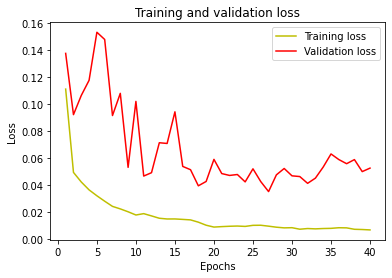

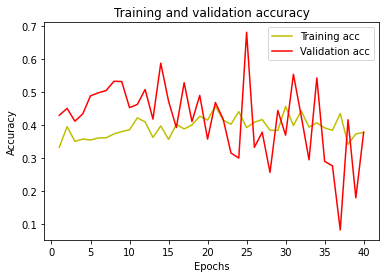

In [34]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [35]:
#IOU
y_pred=model_prop.predict(X_test)
y_pred_thresholded = y_pred > 0.5

from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall

prec_score = Precision()
prec_score.update_state(y_pred_thresholded, y_test)
p = prec_score.result().numpy()
print('Precision Score: %.3f' % p)

recall_score = Recall()
recall_score.update_state(y_pred_thresholded, y_test)
r = recall_score.result().numpy()
print('Recall Score: %.3f' % r)

f1_score = 2*(p*r)/(p+r)
print('F1 Score: %.3f' % f1_score)

Mean IoU = 0.69162023
Precision Score: 0.460
Recall Score: 0.726
F1 Score: 0.564


(1, 128, 128, 3)
(128, 128)


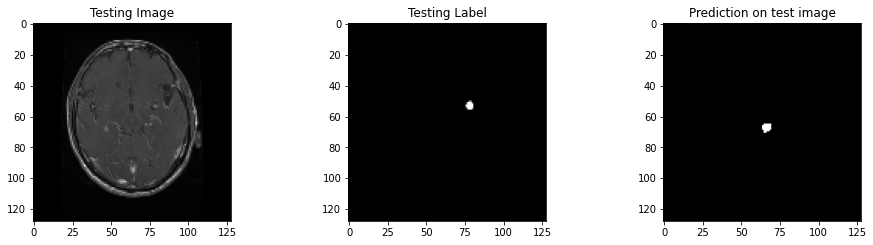

In [36]:
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model_prop.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

### **Stacked UNet**

In [30]:
# Building Unet by dividing encoder and decoder into blocks

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
# from tf.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)
    x1 = Concatenate()([x, input])
    x = Conv2D(num_filters, 3, padding="same")(x1)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)
    x2 = Concatenate()([x, input])
    x = Concatenate()([x1, x2])
    x = Conv2D(num_filters, 1, padding="same")(x)
    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    b1 = conv_block(p4, 512) #Bridge

    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs1 = Conv2D(3, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)
    
    inputs2 = outputs1 + inputs
    
    s1, p1 = encoder_block(inputs2, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    b1 = conv_block(p4, 512) #Bridge

    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs2 = Conv2D(3, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs2, name="Stacked_U-Net")
    return model

In [31]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model_stocked = build_unet(input_shape, n_classes=1)

model_stocked.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model_stocked.summary()

sigmoid
sigmoid
Model: "Stacked_U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_215 (Conv2D)             (None, 128, 128, 32) 896         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_144 (BatchN (None, 128, 128, 32) 128         conv2d_215[0][0]                 
__________________________________________________________________________________________________
activation_144 (Activation)     (None, 128, 128, 32) 0           batch_normalization_144[0][0]    
______________________________________________________________________

In [32]:
history_stacked = model_stocked.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=40, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/40
57/57 [==============================] - 33s 423ms/step - loss: 0.1084 - accuracy: 0.3426 - val_loss: 0.3537 - val_accuracy: 0.2282
Epoch 2/40
57/57 [==============================] - 22s 378ms/step - loss: 0.0511 - accuracy: 0.2693 - val_loss: 0.2871 - val_accuracy: 0.7210
Epoch 3/40
57/57 [==============================] - 22s 378ms/step - loss: 0.0449 - accuracy: 0.2656 - val_loss: 0.2647 - val_accuracy: 0.5014
Epoch 4/40
57/57 [==============================] - 21s 368ms/step - loss: 0.0398 - accuracy: 0.3132 - val_loss: 0.2406 - val_accuracy: 0.3702
Epoch 5/40
57/57 [==============================] - 21s 370ms/step - loss: 0.0369 - accuracy: 0.3027 - val_loss: 0.2181 - val_accuracy: 0.0828
Epoch 6/40
57/57 [==============================] - 21s 373ms/step - loss: 0.0320 - accuracy: 0.2772 - val_loss: 0.2257 - val_accuracy: 0.2086
Epoch 7/40
57/57 [==============================] - 21s 373ms/step - loss: 0.0278 - accuracy: 0.2831 - val_loss: 0.1770 - val_accuracy: 0.1391

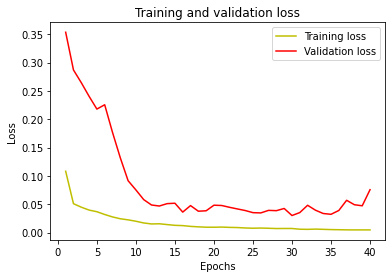

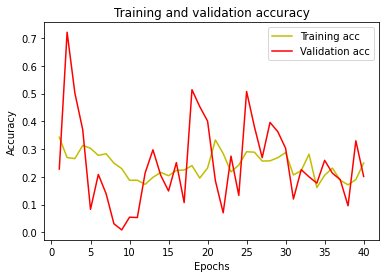

In [33]:
#plot the training and validation accuracy and loss at each epoch
loss = history_stacked.history['loss']
val_loss = history_stacked.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history_stacked.history['accuracy']
val_acc = history_stacked.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [40]:
#IOU
y_pred=model_stocked.predict(X_test)
y_pred_thresholded = y_pred > 0.5

from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall

prec_score = Precision()
prec_score.update_state(y_pred_thresholded, y_test)
p = prec_score.result().numpy()
print('Precision Score: %.3f' % p)

recall_score = Recall()
recall_score.update_state(y_pred_thresholded, y_test)
r = recall_score.result().numpy()
print('Recall Score: %.3f' % r)

f1_score = 2*(p*r)/(p+r)
print('F1 Score: %.3f' % f1_score)

Mean IoU = 0.7192623
Precision Score: 0.458
Recall Score: 0.909
F1 Score: 0.609


(1, 128, 128, 3)
(128, 128)


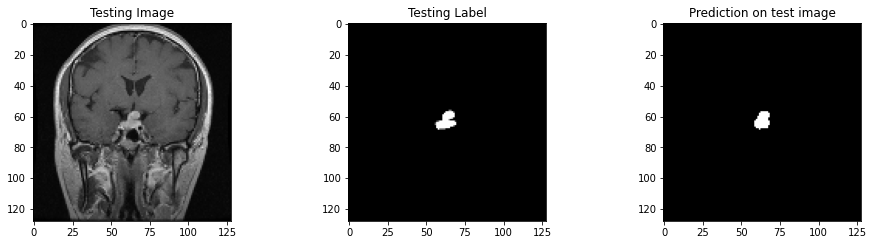

In [35]:
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model_stocked.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()